In [1]:
from diffusers import StableDiffusionPipeline
import torch

/Users/vlzqz/Desktop/escuela/spring 2025/440 social networks/Classmf/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/vlzqz/Desktop/escuela/spring 2025/440 social networks/Classmf/.venv/lib/python3.13/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [2]:
# Configure for M2 Mac (Apple Silicon)
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Load the pipeline with appropriate settings for M2 Mac
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float32,  # Use float32 instead of float16
).to(device)

# Optional: Enable memory efficient attention if needed
pipe.enable_attention_slicing()

Using device: mps


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.02it/s]


100%|██████████| 50/50 [02:56<00:00,  3.52s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


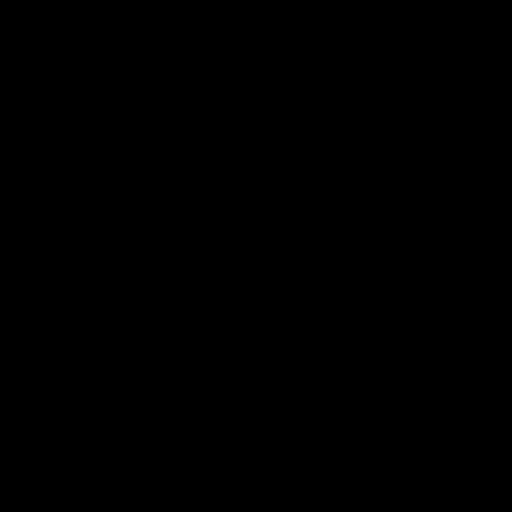

In [10]:
pipe("cartoon screenshot of a banana").images[0]

In [4]:
from transformers import pipeline
prompt = "A photograph of a puppy"


# Turn the text into a sequence of tokens:
text_input = pipe.tokenizer(
    prompt,
    return_tensors="pt",
)

# Output each token and its corresponding ID
for t in text_input["input_ids"][0]:
    print(t, pipe.tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(8853) photograph</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>


In [5]:
text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
print("Text embeddings shape:", text_embeddings.shape)

Text embeddings shape: torch.Size([1, 7, 768])


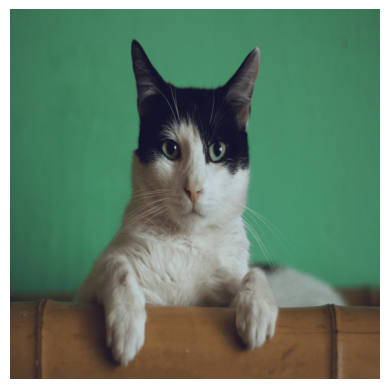

In [6]:
from genaibook.core import load_image, show_image, show_images
import requests
from PIL import Image
from io import BytesIO

# Use a reliable image URL
image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/cat.png"

# Alternative approach to load the image
response = requests.get(image_url)
im = Image.open(BytesIO(response.content))

# Resize if needed
if size := (512, 512):
    im = im.resize(size)

show_image(im);

In [7]:
import torch
from torchvision import transforms
from PIL import Image

with torch.inference_mode():
    # Convert image to RGB mode to ensure 3 channels
    if im.mode != 'RGB':
        im = im.convert('RGB')
    
    # Process image
    tensor_im = transforms.ToTensor()(im).unsqueeze(0).to(device) * 2 - 1
    
    # Check tensor shape to confirm 3 channels
    print(f"Input tensor shape: {tensor_im.shape}")
    
    # Encode the image
    latent = pipe.vae.encode(tensor_im)

    # Sample from the latent distribution
    latents = latent.latent_dist.sample()
    latents = latents * 0.18215

print(f"Latents shape: {latents.shape}")

Input tensor shape: torch.Size([1, 3, 512, 512])
Latents shape: torch.Size([1, 4, 64, 64])


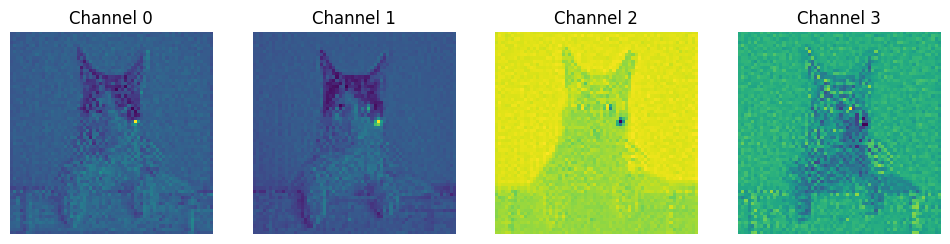

In [8]:
show_images(
    [l for l in latents[0]],
    titles=[f"Channel {i}" for i in range(latents.shape[1])],
    ncols=4,
)

<Axes: >

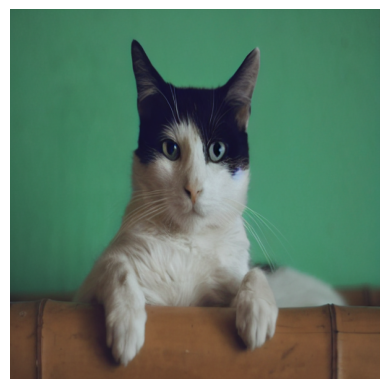

In [9]:
with torch.inference_mode():
    image = pipe.vae.decode(latents / 0.18215).sample
image = (image / 2 + 0.5).clamp(0, 1)
show_image(image[0].float())